<a href="https://colab.research.google.com/github/ranjanchoubey/FedArtML/blob/main/examples/13_Get_started_create_FL_data_label_skew_dirichlet_InSDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Getting started with FedArtML creating FL data (label skew) and implementing an FL model

Our ***FedArTML*** tool facilitates the generation of non-IID datasets
in a controlled way to support federated learning (FL) research for federated datasets from centralized datasets. It includes classes and functions to create federated datasets from centralized data, given the **number** of **clients** and the degree of heterogeneity (**non-IID-ness**) desired.

This guide aims to **understand** using the **SplitAsFederatedData** class to create federated datasets with the **Dirichlet method** for **Label skew**. We use the `InSDN` dataset for our tests. Moreover, we include the `Flower framework` to train an FL model using the output from the FedArtML library.

**Notes:**
1. To check the source code, you can visit the [GitHub repo](https://github.com/Sapienza-University-Rome/FedArtML)
2. To check the documentation, you visit the [dedicated link](https://fedartml.readthedocs.io/en/latest/)

# Install libraries

First, installing the FedArtML and Flower libraries from Pypi (the latest version) is necessary.

In [ ]:
#@title Install FedArtML Library { display-mode: "form" }
!pip install -q fedartml

In [ ]:
#@title Install Flower Framework { display-mode: "form" }
!pip install -q flwr[simulation]

# Import libraries

In [ ]:
#@title Import Libraries & Configure Environment { display-mode: "form" }

import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler

from io import BytesIO
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets, layers, models

import time
import pickle

import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

from sklearn.impute import SimpleImputer

import plotly.graph_objects as go


# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

from fedartml import InteractivePlots, SplitAsFederatedData

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl

from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics

print("✓ All libraries imported successfully!")

# Define parameters

Then it is necessary to define some parameters to run this notebook smoothly. The most important are:



*   `local_nodes_glob`: Defines the desired number of clients (local nodes) the centralized data will be divided into. In this case, we set it as 3.
*   `Alpha`: Using the "Dirichlet-based" method, we need to define the `Alpha`, which will determine the degree of heterogeneity of the client's distribution (non-IID-ness). Notice that the smaller the value of `Alpha`, the higher the non-IID-ness. In this case, we set it as 1. Those parameters can be changed if desired to get familiar with their use.

In [ ]:
#@title Configuration: Federated Learning Parameters { display-mode: "form" }

# Define random state for reproducibility
random_state = 0  # @param {type: "integer", min: 0, max: 10000, step: 1}

# Define number of local nodes (clients)
local_nodes_glob = 5  # @param {type: "integer", min: 2, max: 50, step: 1}

# Distribution Method Selector
distribution_method = "dirichlet"  # @param ["dirichlet", "percent_noniid", "no-label-skew"]

# Dirichlet Alpha Parameter (ONLY used when method='dirichlet')
alpha = 0.001  # @param {type: "number", min: 0.001, max: 10.0, step: 0.1}

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue","#FFFFFF"]

# Path to InSDN dataset
dataset_path = '../data/LINK_all_features_all_datsets/InSDN'

print("\n" + "="*80)
print("FEDERATED LEARNING CONFIGURATION")
print("="*80)
print(f"\n  Number of Clients: {local_nodes_glob}")
print(f"  Distribution Method: {distribution_method.upper()}")
print(f"  Random State (Seed): {random_state}")

print("\n" + "-"*80)
print("DISTRIBUTION METHOD DETAILS:")
print("-"*80)

if distribution_method == "dirichlet":
    print(f"\n  METHOD: Dirichlet Distribution (LABEL SKEW)")
    print(f"  Alpha parameter: {alpha}")
    print(f"\n  Description:")
    print(f"    - Creates non-IID (heterogeneous) data distribution")
    print(f"    - Each client gets a different set of labels")
    print(f"    - Alpha controls degree of heterogeneity:")
    print(f"      * α < 0.5: Extreme heterogeneity (highly non-IID)")
    print(f"      * α = 1.0: Moderate heterogeneity")
    print(f"      * α > 5.0: Near-uniform distribution (near IID)")
    print(f"\n  Use case: Realistic federated scenarios with label skew")

elif distribution_method == "percent_noniid":
    print(f"\n  METHOD: Percent Non-IID Distribution")
    print(f"  Heterogeneity parameter: {alpha}")
    print(f"\n  Description:")
    print(f"    - Alternative method for creating non-IID data")
    print(f"    - Based on percentage of non-IID samples")
    print(f"    - Parameter ranges 0-1 (0=IID, 1=max heterogeneity)")
    print(f"\n  Use case: Controlled heterogeneity testing")

elif distribution_method == "no-label-skew":
    print(f"\n  METHOD: No Label Skew (IID Distribution)")
    print(f"\n  Description:")
    print(f"    - Creates Independent and Identically Distributed data")
    print(f"    - Each client has balanced class distribution")
    print(f"    - All clients have similar label proportions")
    print(f"\n  Use case: Baseline/control experiments for comparison")

print("\n" + "="*80)
print(f"✓ READY: {local_nodes_glob} clients will be created with {distribution_method} method")
print("="*80 + "\n")

# Define functions

For the sake of order, we defined some functions that will be used in this guide.

In [ ]:
#@title Define Helper Functions { display-mode: "form" }

# Define function to test a model and retrieve classification metrics
def test_model(model, X_test, Y_test):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
    logits = model.predict(X_test, batch_size=32, verbose=1, callbacks=[GarbageCollectorCallback()])
    y_pred = tf.argmax(logits, axis=1)
    loss = cce(Y_test, logits).numpy()
    acc = accuracy_score(y_pred, Y_test)
    pre = precision_score(y_pred, Y_test, average='weighted',zero_division = 0)
    rec = recall_score(y_pred, Y_test, average='weighted',zero_division = 0)
    f1s = f1_score(y_pred, Y_test, average='weighted',zero_division = 0)

    return loss, acc, pre, rec, f1s

# Define function to convert from SplitAsFederatedData function output (FedArtML) to Flower (list) format
def from_FedArtML_to_Flower_format(clients_dict):
  # initialize list that contains clients (features and labels) to extract later from client_fn in Flower
  list_x_train = []
  list_y_train = []

  # Get the name of the clients from the dictionary
  client_names = list(clients_dict.keys())

  # Iterate over each client
  for client in client_names:
    # Get data from each client
    each_client_train=np.array(clients_dict[client],dtype=object)

    # Extract features for each client
    feat=[]
    x_tra=np.array(each_client_train[:, 0])
    for row in x_tra:
      feat.append(row)
    feat=np.array(feat)

    # Extract labels from each client
    y_tra=np.array(each_client_train[:, 1])

    # Append in list features and labels to extract later from client_fn in Flower
    list_x_train.append(feat)
    list_y_train.append(y_tra)

  return list_x_train, list_y_train

# Define Dense Neural Network (DNN) model for tabular InSDN data
def DNN_model(input_shape, num_classes):
  model = models.Sequential()
  model.add(layers.Input(shape=(input_shape,)))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(num_classes, activation='softmax'))

  return model


# Define local training/evaluation function
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test, epochs_client) -> None:
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.epochs_client = epochs_client

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, validation_split=0.1, epochs=self.epochs_client, verbose=2)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}

def plot_metric_from_history(
    hist: None,
    save_plot_path: None,
    metric_type: None,
    metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    save_plot_path : Path
        Folder to save the plot to.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to plot.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to plot.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    # plt.plot(np.asarray(rounds), np.asarray(values), label="FedAvg")
    plt.plot(np.asarray(rounds), np.asarray(values), color=colors[5], linewidth=5, label='Test')
    plt.legend(fontsize=45)
    plt.xlabel('Communication round', fontsize=40)
    plt.ylabel(metric, fontsize=50)
    plt.title(metric, fontsize=60)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    # plt.ylim(min(min(min(commun_metrics))) - 0.05, max(max(max(commun_metrics))) + 0.05)
    plt.ylim(0, 1)
    # plt.savefig(Path(save_plot_path) / Path(f"{metric_type}_metrics{suffix}.png"))
    # plt.close()

def retrieve_global_metrics(
    hist: None,
    metric_type: None,
    metric: None,
    best_metric: None,
) -> None:
    """Function to retrieve metrics from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to retrieve.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to retrieve.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    if best_metric:
      metric_return = max(values)
    else:
      metric_return = values[-1]
    return metric_return

print("✓ All helper functions defined successfully!")

# Load and preprocess InSDN data

The InSDN dataset consists of network traffic data with various features. We will load, preprocess, and split the data into training and test sets.

In [ ]:
#@title Load InSDN Dataset from Official Source { display-mode: "form" }

# Load InSDN dataset from official UCD source
# InSDN: SDN Intrusion Detection Dataset
# Source: https://aseados.ucd.ie/datasets/SDN/
# Paper: "InSDN: SDN Intrusion Dataset" IEEE Access Vol.8, pp 165263-165284, Sep 2020

import zipfile
import io

print("Loading InSDN dataset...")
print("Dataset Information:")
print("  - Total instances: 343,939 network flow records")
print("  - Normal traffic: 68,424 (20%)")
print("  - Attack traffic: 275,515 (80%)")
print("  - Features: 80+ network flow characteristics")
print("  - Attack types: DoS, DDoS, Probe, Brute Force, Exploitation, Web Attack, Botnet")

df = None

# Option 1: Try to load from local path first
try:
    if os.path.exists(dataset_path):
        data_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
        if data_files:
            print(f"\n✓ Found local dataset: {data_files[0]}")
            df = pd.read_csv(os.path.join(dataset_path, data_files[0]))
except Exception as e:
    print(f"Local path check failed: {e}")

# Option 2: Download from official UCD source
if df is None:
    try:
        print("\n✓ Attempting to download official InSDN dataset from UCD...")
        zip_url = "https://aseados.ucd.ie/datasets/SDN/InSDN_DatasetCSV.zip"

        response = requests.get(zip_url, timeout=30)
        if response.status_code == 200:
            print("  Download successful! Extracting dataset...")

            # Extract and load the zip file
            zip_file = zipfile.ZipFile(io.BytesIO(response.content))
            csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]

            if csv_files:
                # Prefer OVS.csv for more attack variety
                selected_file = next((f for f in csv_files if 'OVS.csv' in f), csv_files[0])
                print(f"  Loading: {selected_file}")
                df = pd.read_csv(zip_file.open(selected_file))
                print(f"✓ Successfully loaded InSDN dataset! Shape: {df.shape}")
    except Exception as e:
        print(f"Download failed: {e}")

# If download fails, provide instructions
if df is None or df.empty:
    print("\n" + "="*80)
    print("Could not load dataset automatically")
    print("="*80)
    print("\nPlease download manually from:")
    print("  https://aseados.ucd.ie/datasets/SDN/")
    print("\nSteps:")
    print("  1. Download: InSDN_DatasetCSV.zip")
    print("  2. Extract the ZIP file")
    print("  3. Choose one CSV file:")
    print("     - OVS.csv (136,743 records - recommended for variety)")
    print("     - metasploitable-2.csv (138,772 records)")
    print("     - Normal_data.csv (68,424 records - benign traffic only)")
    print(f"  4. Place in: {os.path.abspath(dataset_path)}")
    print("="*80)
    df = pd.DataFrame()

# Display dataset information
if not df.empty:
    print("\n" + "="*80)
    print("InSDN Dataset Loaded Successfully!")
    print("="*80)
    print(f"Shape: {df.shape[0]} records x {df.shape[1]} features")
    print(f"\nFirst few rows:")
    print(df.head())
    print(f"\nColumn names ({len(df.columns)} total):")
    print(df.columns.tolist())


In [ ]:
#@title Preprocess InSDN Data { display-mode: "form" }

# Preprocess InSDN data
if not df.empty:
    print("\n" + "="*80)
    print("Preprocessing InSDN Data")
    print("="*80)

    print(f"\nDataFrame shape: {df.shape}")
    print(f"Column names (first 10): {list(df.columns[:10])}")

    # The InSDN dataset has 'Label' column (uppercase L)
    if 'Label' in df.columns:
        y_raw = df['Label'].values
        print(f"\n✓ Found 'Label' column")
        print(f"  Unique labels: {np.unique(y_raw)}")
        print(f"  Label counts: {pd.Series(y_raw).value_counts().to_dict()}")

        # Drop the Label column and non-numeric metadata columns
        X_df = df.drop(columns=['Label', 'Flow ID', 'Src IP', 'Dst IP', 'Timestamp'], errors='ignore')
    else:
        print("ERROR: 'Label' column not found!")
        print(f"Available columns: {list(df.columns)}")
        raise ValueError("'Label' column not found in dataset")

    # Select only numeric columns for features
    X_df = X_df.select_dtypes(include=[np.number])
    print(f"\nNumeric features shape: {X_df.shape}")
    print(f"Feature columns: {list(X_df.columns[:10])}... (showing first 10)")

    X = X_df.values

    # Convert labels to numeric (they are strings like 'BFA', 'DoS', etc.)
    unique_labels = sorted(set(y_raw))
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    y = np.array([label_mapping[label] for label in y_raw]).astype(int)

    print(f"\nLabel mapping ({len(label_mapping)} classes):")
    for label, idx in label_mapping.items():
        print(f"  {label} -> {idx}")

    print(f"\nLabel information:")
    print(f"  - Unique numeric labels: {sorted(np.unique(y))}")
    print(f"  - Label range: [{y.min()}, {y.max()}]")

    # Check class distribution
    unique_classes, class_counts = np.unique(y, return_counts=True)
    print(f"\nOriginal class distribution:")
    for cls, count in zip(unique_classes, class_counts):
        original_label = [k for k, v in label_mapping.items() if v == cls][0]
        print(f"  Class {cls} ({original_label}): {count} samples ({100*count/len(y):.1f}%)")

    # Handle missing values in features
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    print("\n✓ Missing values handled (mean imputation)")

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    print("✓ Features normalized (StandardScaler)")

    # Remove classes with very few samples (< 2) to avoid stratification issues
    min_samples_per_class = 2
    valid_classes = unique_classes[class_counts >= min_samples_per_class]
    mask = np.isin(y, valid_classes)
    X = X[mask]
    y = y[mask]

    print(f"\nFiltered class distribution (removed classes with < {min_samples_per_class} samples):")
    unique_classes, class_counts = np.unique(y, return_counts=True)
    for cls, count in zip(unique_classes, class_counts):
        original_label = [k for k, v in label_mapping.items() if v == cls][0]
        print(f"  Class {cls} ({original_label}): {count} samples ({100*count/len(y):.1f}%)")

    # Split into train and test sets
    # Use stratified split if possible, otherwise use random split
    try:
        x_train_glob, x_test_glob, y_train_glob, y_test_glob = train_test_split(
            X, y, test_size=0.2, random_state=random_state, stratify=y
        )
        print("\n✓ Used stratified train-test split")
    except ValueError:
        # If stratification fails, use random split
        x_train_glob, x_test_glob, y_train_glob, y_test_glob = train_test_split(
            X, y, test_size=0.2, random_state=random_state, stratify=None
        )
        print("✓ Used random train-test split (stratification not possible)")

    # Get dataset statistics
    num_classes = len(np.unique(y_train_glob))
    input_shape = x_train_glob.shape[1]

    print(f"\nDataset Statistics:")
    print(f"  - Training set: {x_train_glob.shape}")
    print(f"  - Test set: {x_test_glob.shape}")
    print(f"  - Number of classes: {num_classes}")
    print(f"  - Input shape: {input_shape}")
    print(f"  - Label range (train): [{y_train_glob.min()}, {y_train_glob.max()}]")
    print(f"  - Label range (test): [{y_test_glob.min()}, {y_test_glob.max()}]")
    print(f"\nClass distribution in training set:")
    unique, counts = np.unique(y_train_glob, return_counts=True)
    for cls, count in zip(unique, counts):
        pct = 100 * count / len(y_train_glob)
        original_label = [k for k, v in label_mapping.items() if v == cls][0]
        print(f"    Class {cls} ({original_label}): {count} samples ({pct:.1f}%)")
else:
    print("Cannot preprocess - dataset is empty")


In [ ]:
#@title Visualize Class Distributions { display-mode: "form" }

# Visualize class distributions
if not df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Training set
    unique_train, counts_train = np.unique(y_train_glob, return_counts=True)
    axes[0].bar(unique_train, counts_train, color=colors[0], alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Label', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title('Training Set Label Distribution', fontsize=14)
    axes[0].grid(axis='y', alpha=0.3)

    # Test set
    unique_test, counts_test = np.unique(y_test_glob, return_counts=True)
    axes[1].bar(unique_test, counts_test, color=colors[1], alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Label', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title('Test Set Label Distribution', fontsize=14)
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


# Create the federated dataset

This core function allows the creation of FL data from centralized data. The class `SplitAsFederatedData` is instantiated using a `random_state` to reproduce the results.

Then, the `.create_clients` function performs the federation of the centralized data by taking the features and labels, defining the number of desired clients and setting the Alpha value.

**Note:** When creating federated data and setting heterogeneous distributions (i.e. high values of percent_noniid or small values of Alpha), it is more likely the clients hold examples from only one class. Then, two cases are returned as output for fed_data and distances:
- "with_class_completion": In this case, the clients are completed with one (random) example of each missing class for each client to have all the label's classes.
- "without_class_completion": In this case, the clients are NOT completed with one (random) example of each missing class.

In [ ]:
if not df.empty:
    # Instantiate a SplitAsFederatedData object
    my_federater = SplitAsFederatedData(random_state = random_state)

    # Get federated dataset from centralized dataset
    clients_glob_dic, list_ids_sampled_dic, miss_class_per_node, distances = my_federater.create_clients(
        image_list = x_train_glob,
        label_list = y_train_glob,
        num_clients = local_nodes_glob,
        prefix_cli='Local_node',
        method = "percent_noniid",
        alpha = 0
    )

    clients_glob = clients_glob_dic['without_class_completion']
    list_ids_sampled = list_ids_sampled_dic['without_class_completion']

    # Convert from SplitAsFederatedData function output (FedArtML) to Flower (list) format
    list_x_train, list_y_train = from_FedArtML_to_Flower_format(clients_dict=clients_glob)

    print("Federated dataset created successfully!")
    print(f"Number of clients: {len(list_x_train)}")

Check the distributions of created clients

In [ ]:
if not df.empty:
    ## Check distributions of created clients
    # Define dimensions for plot
    f, axs = plt.subplots(1, local_nodes_glob, figsize=(20, 5))

    # Initialize counter
    cont = 0
    max_xlab = 0.4 + 0.02
    fl_append_labels = []

    # Loop over the clients
    for key, value in clients_glob.items():
      # Extract the labels
      labels_check = []
      for i in range(len(value)):
        val = value[i][1]
        labels_check.append(val)

      fl_append_labels = fl_append_labels + list(labels_check[:len(labels_check)-miss_class_per_node[cont]])

      labels_check = pd.DataFrame(labels_check, columns=["label"]).reset_index()

      # Get the number of diagnoses per diagnose
      group = labels_check.groupby(['label']).count().reset_index().sort_values(by=['label'], ascending = True)
      group['particip'] = group['index'].values / sum(group['index'].values)
      group.sort_values(by=['label'], ascending=False, inplace=True)

      print(f"Local node {cont + 1} shape: {labels_check[:len(labels_check)-miss_class_per_node[cont]].shape}")

      # Plot each client barplot
      max_group = max(group['particip'])
      max_xlab = np.min([max_xlab, max_group])
      plt.subplot(1, local_nodes_glob, cont + 1)
      plt.barh(group.label, group['particip'], alpha = 1, color=colors[0])
      plt.xlabel('Participation (%)', fontsize=12)
      plt.ylabel('Label', fontsize=12)
      plt.title(key.replace("_", " "), fontsize=14)
      plt.xticks(fontsize=10)
      plt.yticks(fontsize=10)
      plt.xlim(left=0, right=max_xlab + 0.02)
      # Increase counter
      cont += 1

    plt.tight_layout()
    plt.show()

In [ ]:
if not df.empty:
    # Calculate distances
    JSD_glob = distances['without_class_completion']['jensen-shannon']
    print("Jensen-Shannon distance:", JSD_glob)
    HD_glob = distances['without_class_completion']['hellinger']
    print("Hellinger distance:", HD_glob)
    EMD_glob = distances['without_class_completion']['earth-movers']
    print("Earth Mover's distance:", EMD_glob)

# Train with Dense Neural Network (DNN)

Up to this point, we have shown how to use the **FedArtML** to create a federated dataset starting from centralized data. Then, we introduce the code to train an FL model using the **Flower framework**.

In [ ]:
# Configure training parameters
if not df.empty:
    # Define loss and metrics
    loss_inic = SparseCategoricalCrossentropy()
    metrics = SparseCategoricalAccuracy()

    # Training configuration
    epochs = 2
    comms_round = 2

    print("\nTraining Configuration:")
    print(f"  - Local epochs per round: {epochs}")
    print(f"  - Communication rounds: {comms_round}")
    print(f"  - Number of clients: {local_nodes_glob}")
    print(f"  - Input shape: {input_shape}")
    print(f"  - Output classes: {num_classes}")


In [ ]:
if not df.empty:
    # The `evaluate` function will be by Flower called after every round
    def evaluate_DNN(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
        net = DNN_model(input_shape, num_classes)
        net.set_weights(parameters) # Update model with the latest parameters
        loss, accuracy, precision, recall, f1score  = test_model(net, x_test_glob, np.array(y_test_glob))
        print(f"@@@@@@ Server-side evaluation loss {loss} / accuracy {accuracy} / f1score {f1score} @@@@@@")
        return loss, {"accuracy": accuracy,"precision": precision,"recall": recall,"f1score": f1score}

In [78]:
if not df.empty:
    print("\n" + "="*80)
    print("Starting Federated Learning Training")
    print("="*80)

    # Define client function
    def client_fn(cid: str) -> fl.client.Client:
        # Create model
        model = DNN_model(input_shape, num_classes)
        model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_inic, metrics=[metrics])

        # Load client data partition
        x_train_cid = np.array(list_x_train[int(cid)], dtype=float)
        y_train_cid = np.array(list_y_train[int(cid)], dtype=float)

        return FlowerClient(model, x_train_cid, y_train_cid, x_test_glob, y_test_glob, epochs)

    # Create FedAvg strategy
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=local_nodes_glob,
        min_evaluate_clients=local_nodes_glob // 2,
        min_available_clients=local_nodes_glob,
        evaluate_fn=evaluate_DNN
    )

    # Run federated learning simulation
    start_time = time.time()
    commun_metrics_history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=local_nodes_glob,
        config=fl.server.ServerConfig(num_rounds=comms_round),
        strategy=strategy,
    )
    training_time = time.time() - start_time

    # Extract final metrics
    global_acc_test = retrieve_global_metrics(commun_metrics_history, "centralized", "accuracy", False)
    global_pre_test = retrieve_global_metrics(commun_metrics_history, "centralized", "precision", False)
    global_rec_test = retrieve_global_metrics(commun_metrics_history, "centralized", "recall", False)
    global_f1s_test = retrieve_global_metrics(commun_metrics_history, "centralized", "f1score", False)

    print("\n" + "="*80)
    print("FINAL RESULTS")
    print("="*80)
    print(f"Accuracy:  {global_acc_test:.4f}")
    print(f"Precision: {global_pre_test:.4f}")
    print(f"Recall:    {global_rec_test:.4f}")
    print(f"F1-Score:  {global_f1s_test:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print("="*80)


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout



Starting Federated Learning Training


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

2025-12-09 08:31:56,128	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 9275807744.0, 'object_store_memory': 3975346176.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=gcs_ser

868/868 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


INFO :      initial parameters (loss, other metrics): 1.9978144, {'accuracy': 0.061921066858893495, 'precision': 0.35791995364486934, 'recall': 0.061921066858893495, 'f1score': 0.025458828327206192}
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


@@@@@@ Server-side evaluation loss 1.997814416885376 / accuracy 0.061921066858893495 / f1score 0.025458828327206192 @@@@@@


(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40323)             entirely in future versions of Flower.
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         


(ClientAppActor pid=40323) Epoch 1/2


(ClientAppActor pid=40324) [2025-12-09 08:32:40,040 E 40324 40454] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=40324) 620/620 - 9s - 14ms/step - loss: 0.2594 - sparse_categorical_accuracy: 0.9234 - val_loss: 0.0494 - val_sparse_categorical_accuracy: 0.9909
(ClientAppActor pid=40324) Epoch 2/2 [repeated 2x across cluster]


(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) [2025-12-09 08:32:40,863 E 40323 40488] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exp

(ClientAppActor pid=40323) 634/634 - 4s - 7ms/step - loss: 0.0663 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.0555 - val_sparse_categorical_accuracy: 0.9889 [repeated 3x across cluster]
(ClientAppActor pid=40323) Epoch 1/2 [repeated 3x across cluster]
(ClientAppActor pid=40324) 623/623 - 4s - 6ms/step - loss: 0.0642 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.0457 - val_sparse_categorical_accuracy: 0.9883 [repeated 2x across cluster]
(ClientAppActor pid=40324) Epoch 2/2


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=40324)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned

(ClientAppActor pid=40324) Epoch 1/2
(ClientAppActor pid=40324) 618/618 - 14s - 22ms/step - loss: 0.2658 - sparse_categorical_accuracy: 0.9225 - val_loss: 0.0571 - val_sparse_categorical_accuracy: 0.9859 [repeated 3x across cluster]
(ClientAppActor pid=40324) Epoch 2/2 [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


868/868 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


INFO :      fit progress: (1, 0.042051006, {'accuracy': 0.989403496125428, 'precision': 0.9953435984082937, 'recall': 0.989403496125428, 'f1score': 0.9920601466292597}, 41.624224567000056)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)


@@@@@@ Server-side evaluation loss 0.042051006108522415 / accuracy 0.989403496125428 / f1score 0.9920601466292597 @@@@@@


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40323)             entirely in future versions of Flower.
(ClientAppActor pid=4032

(ClientAppActor pid=40324) 868/868 - 4s - 5ms/step - loss: 0.0425 - sparse_categorical_accuracy: 0.9894
(ClientAppActor pid=40324) 618/618 - 2s - 3ms/step - loss: 0.0667 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0416 - val_sparse_categorical_accuracy: 0.9868


(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40323)             entirely in future versions of Flower.
(ClientAppActor pid=40323)         
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions

(ClientAppActor pid=40323) Epoch 1/2
(ClientAppActor pid=40323) 623/623 - 7s - 11ms/step - loss: 0.0460 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0298 - val_sparse_categorical_accuracy: 0.9892
(ClientAppActor pid=40323) 868/868 - 4s - 5ms/step - loss: 0.0425 - sparse_categorical_accuracy: 0.9894
(ClientAppActor pid=40323) Epoch 2/2 [repeated 2x across cluster]


(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40323)             entirely in future versions of Flower.
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=40324) 618/618 - 6s - 9ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.0309 - val_sparse_categorical_accuracy: 0.9900 [repeated 3x across cluster]
(ClientAppActor pid=40323) Epoch 1/2 [repeated 2x across cluster]


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=40323) 634/634 - 8s - 13ms/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.0458 - val_sparse_categorical_accuracy: 0.9907
(ClientAppActor pid=40324) Epoch 1/2
(ClientAppActor pid=40323) Epoch 2/2
(ClientAppActor pid=40323) 634/634 - 3s - 5ms/step - loss: 0.0369 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.0323 - val_sparse_categorical_accuracy: 0.9929


(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40323)             entirely in future versions of Flower.
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=40323) Epoch 1/2 [repeated 2x across cluster]
(ClientAppActor pid=40324) 620/620 - 6s - 10ms/step - loss: 0.0397 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.0267 - val_sparse_categorical_accuracy: 0.9941 [repeated 2x across cluster]
(ClientAppActor pid=40323) Epoch 2/2


INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=40323) 629/629 - 2s - 3ms/step - loss: 0.0361 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.0228 - val_sparse_categorical_accuracy: 0.9946 [repeated 2x across cluster]
868/868 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


INFO :      fit progress: (2, 0.026022717, {'accuracy': 0.9936204721571454, 'precision': 0.9962864389330738, 'recall': 0.9936204721571454, 'f1score': 0.9949382888908654}, 80.70610689099976)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)


@@@@@@ Server-side evaluation loss 0.026022717356681824 / accuracy 0.9936204721571454 / f1score 0.9949382888908654 @@@@@@


(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40323)             entirely in future versions of Flower.
(ClientAppActor pid=40323)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=4032

(ClientAppActor pid=40323) 868/868 - 2s - 3ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9936


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         


(ClientAppActor pid=40323) Epoch 1/2
(ClientAppActor pid=40324) 623/623 - 9s - 14ms/step - loss: 0.0320 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.0246 - val_sparse_categorical_accuracy: 0.9892
(ClientAppActor pid=40324) 868/868 - 3s - 3ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9936
(ClientAppActor pid=40324) Epoch 2/2 [repeated 2x across cluster]


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         


(ClientAppActor pid=40323) 629/629 - 3s - 5ms/step - loss: 0.0272 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.0292 - val_sparse_categorical_accuracy: 0.9933 [repeated 3x across cluster]
(ClientAppActor pid=40324) Epoch 1/2 [repeated 3x across cluster]
(ClientAppActor pid=40323) 634/634 - 8s - 13ms/step - loss: 0.0345 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.0263 - val_sparse_categorical_accuracy: 0.9924
(ClientAppActor pid=40323) Epoch 2/2
(ClientAppActor pid=40323) 634/634 - 3s - 5ms/step - loss: 0.0307 - sparse_categorical_accuracy: 0.9929 - val_loss: 0.0220 - val_sparse_categorical_accuracy: 0.9942


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=40324) Epoch 2/2
(ClientAppActor pid=40323) 620/620 - 6s - 9ms/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.0285 - val_sparse_categorical_accuracy: 0.9927 [repeated 3x across cluster]
(ClientAppActor pid=40323) Epoch 2/2 [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


868/868 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


INFO :      fit progress: (3, 0.021134518, {'accuracy': 0.994233195170301, 'precision': 0.9966439926053027, 'recall': 0.994233195170301, 'f1score': 0.9954298487806851}, 118.41040686399992)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)


@@@@@@ Server-side evaluation loss 0.021134518086910248 / accuracy 0.994233195170301 / f1score 0.9954298487806851 @@@@@@


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.c

(ClientAppActor pid=40323) 868/868 - 2s - 3ms/step - loss: 0.0227 - sparse_categorical_accuracy: 0.9942
(ClientAppActor pid=40323) 620/620 - 3s - 5ms/step - loss: 0.0299 - sparse_categorical_accuracy: 0.9929 - val_loss: 0.0283 - val_sparse_categorical_accuracy: 0.9937


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         


(ClientAppActor pid=40324) Epoch 1/2
(ClientAppActor pid=40323) 623/623 - 9s - 14ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.0189 - val_sparse_categorical_accuracy: 0.9932
(ClientAppActor pid=40324) 868/868 - 3s - 3ms/step - loss: 0.0227 - sparse_categorical_accuracy: 0.9942
(ClientAppActor pid=40323) Epoch 2/2 [repeated 2x across cluster]


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         


(ClientAppActor pid=40324) 620/620 - 3s - 5ms/step - loss: 0.0271 - sparse_categorical_accuracy: 0.9932 - val_loss: 0.0248 - val_sparse_categorical_accuracy: 0.9937 [repeated 3x across cluster]
(ClientAppActor pid=40324) Epoch 1/2 [repeated 3x across cluster]
(ClientAppActor pid=40323) 618/618 - 5s - 9ms/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9932 - val_loss: 0.0232 - val_sparse_categorical_accuracy: 0.9941 [repeated 2x across cluster]
(ClientAppActor pid=40323) Epoch 2/2
(ClientAppActor pid=40324) Epoch 2/2


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=40324) 629/629 - 8s - 12ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.0197 - val_sparse_categorical_accuracy: 0.9960 [repeated 3x across cluster]
(ClientAppActor pid=40323) Epoch 2/2 [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


868/868 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


INFO :      fit progress: (4, 0.01911724, {'accuracy': 0.9943773652910435, 'precision': 0.9968086611620324, 'recall': 0.9943773652910435, 'f1score': 0.995586236649967}, 157.40984892399956)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)


@@@@@@ Server-side evaluation loss 0.019117239862680435 / accuracy 0.9943773652910435 / f1score 0.995586236649967 @@@@@@


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.c

(ClientAppActor pid=40324) 868/868 - 2s - 3ms/step - loss: 0.0236 - sparse_categorical_accuracy: 0.9944
(ClientAppActor pid=40323) 634/634 - 3s - 5ms/step - loss: 0.0281 - sparse_categorical_accuracy: 0.9928 - val_loss: 0.0262 - val_sparse_categorical_accuracy: 0.9929


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         


(ClientAppActor pid=40324) Epoch 1/2
(ClientAppActor pid=40323) 623/623 - 7s - 11ms/step - loss: 0.0217 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.0169 - val_sparse_categorical_accuracy: 0.9955
(ClientAppActor pid=40323) 868/868 - 2s - 3ms/step - loss: 0.0236 - sparse_categorical_accuracy: 0.9944
(ClientAppActor pid=40323) Epoch 2/2 [repeated 2x across cluster]


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         


(ClientAppActor pid=40323) 623/623 - 5s - 7ms/step - loss: 0.0232 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.0304 - val_sparse_categorical_accuracy: 0.9923 [repeated 3x across cluster]
(ClientAppActor pid=40324) Epoch 1/2 [repeated 3x across cluster]
(ClientAppActor pid=40323) 634/634 - 7s - 11ms/step - loss: 0.0247 - sparse_categorical_accuracy: 0.9943 - val_loss: 0.0388 - val_sparse_categorical_accuracy: 0.9902
(ClientAppActor pid=40323) Epoch 2/2
(ClientAppActor pid=40324) 629/629 - 7s - 11ms/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.0295 - val_sparse_categorical_accuracy: 0.9955
(ClientAppActor pid=40324) Epoch 2/2


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=40323) 620/620 - 6s - 10ms/step - loss: 0.0264 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.0256 - val_sparse_categorical_accuracy: 0.9941 [repeated 3x across cluster]
(ClientAppActor pid=40323) Epoch 2/2 [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


868/868 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


INFO :      fit progress: (5, 0.01843055, {'accuracy': 0.9955667687871689, 'precision': 0.996919131139247, 'recall': 0.9955667687871689, 'f1score': 0.9962395253993388}, 194.78637651899953)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)


@@@@@@ Server-side evaluation loss 0.018430549651384354 / accuracy 0.9955667687871689 / f1score 0.9962395253993388 @@@@@@


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.c

(ClientAppActor pid=40324) 868/868 - 4s - 5ms/step - loss: 0.0240 - sparse_categorical_accuracy: 0.9956
(ClientAppActor pid=40323) 620/620 - 2s - 3ms/step - loss: 0.0255 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.0291 - val_sparse_categorical_accuracy: 0.9955


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 2x across cluster]


(ClientAppActor pid=40323) Epoch 1/2
(ClientAppActor pid=40324) 629/629 - 7s - 11ms/step - loss: 0.0240 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.0189 - val_sparse_categorical_accuracy: 0.9951
(ClientAppActor pid=40323) 868/868 - 4s - 5ms/step - loss: 0.0240 - sparse_categorical_accuracy: 0.9956
(ClientAppActor pid=40324) Epoch 2/2 [repeated 2x across cluster]


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.


(ClientAppActor pid=40323) 634/634 - 6s - 10ms/step - loss: 0.0247 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.0244 - val_sparse_categorical_accuracy: 0.9956 [repeated 3x across cluster]
(ClientAppActor pid=40324) Epoch 1/2 [repeated 2x across cluster]


(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40323)             entirely in future versions of Flower.
(ClientAppActor pid=40323)         


(ClientAppActor pid=40324) 620/620 - 9s - 14ms/step - loss: 0.0248 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0407 - val_sparse_categorical_accuracy: 0.9955
(ClientAppActor pid=40324) Epoch 2/2 [repeated 2x across cluster]
(ClientAppActor pid=40323) 623/623 - 7s - 11ms/step - loss: 0.0211 - sparse_categorical_accuracy: 0.9946 - val_loss: 0.0213 - val_sparse_categorical_accuracy: 0.9923


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.


(ClientAppActor pid=40324) Epoch 1/2 [repeated 2x across cluster]
(ClientAppActor pid=40324) 618/618 - 6s - 10ms/step - loss: 0.0218 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.0181 - val_sparse_categorical_accuracy: 0.9945 [repeated 3x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=40324) Epoch 2/2
868/868 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


INFO :      fit progress: (6, 0.016715098, {'accuracy': 0.9957109389079113, 'precision': 0.9970553475048027, 'recall': 0.9957109389079113, 'f1score': 0.9963793370867714}, 233.18546439799957)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)


@@@@@@ Server-side evaluation loss 0.016715098172426224 / accuracy 0.9957109389079113 / f1score 0.9963793370867714 @@@@@@


(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClie

(ClientAppActor pid=40324) 868/868 - 3s - 3ms/step - loss: 0.0194 - sparse_categorical_accuracy: 0.9957
(ClientAppActor pid=40324) 618/618 - 2s - 3ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.0183 - val_sparse_categorical_accuracy: 0.9945


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         


(ClientAppActor pid=40324) Epoch 1/2
(ClientAppActor pid=40324) 634/634 - 8s - 13ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.0293 - val_sparse_categorical_accuracy: 0.9960
(ClientAppActor pid=40323) 868/868 - 3s - 3ms/step - loss: 0.0194 - sparse_categorical_accuracy: 0.9957
(ClientAppActor pid=40324) Epoch 2/2 [repeated 2x across cluster]


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=40324) 634/634 - 5s - 8ms/step - loss: 0.0194 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.0376 - val_sparse_categorical_accuracy: 0.9933 [repeated 3x across cluster]
(ClientAppActor pid=40323) Epoch 1/2 [repeated 2x across cluster]


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         


(ClientAppActor pid=40323) 620/620 - 9s - 14ms/step - loss: 0.0231 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0231 - val_sparse_categorical_accuracy: 0.9955
(ClientAppActor pid=40323) Epoch 2/2 [repeated 2x across cluster]
(ClientAppActor pid=40323) 620/620 - 3s - 5ms/step - loss: 0.0228 - sparse_categorical_accuracy: 0.9946 - val_loss: 0.0178 - val_sparse_categorical_accuracy: 0.9955


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=40324) Epoch 2/2 [repeated 2x across cluster]
(ClientAppActor pid=40324) 629/629 - 5s - 7ms/step - loss: 0.0177 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0148 - val_sparse_categorical_accuracy: 0.9951 [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


868/868 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


INFO :      fit progress: (7, 0.015708037, {'accuracy': 0.9961074067399531, 'precision': 0.9975101632680895, 'recall': 0.9961074067399531, 'f1score': 0.9968023415073936}, 272.07518926099965)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)


@@@@@@ Server-side evaluation loss 0.015708036720752716 / accuracy 0.9961074067399531 / f1score 0.9968023415073936 @@@@@@


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40323)             entirely in future versions of Flower.
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.c

(ClientAppActor pid=40324) 868/868 - 2s - 3ms/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9961
(ClientAppActor pid=40323) Epoch 2/2
(ClientAppActor pid=40323) 618/618 - 3s - 5ms/step - loss: 0.0188 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.0166 - val_sparse_categorical_accuracy: 0.9964 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40324)         
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         


(ClientAppActor pid=40324) Epoch 1/2
(ClientAppActor pid=40323) 868/868 - 2s - 3ms/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9961
(ClientAppActor pid=40324) 629/629 - 8s - 13ms/step - loss: 0.0155 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0157 - val_sparse_categorical_accuracy: 0.9951
(ClientAppActor pid=40324) Epoch 2/2 [repeated 2x across cluster]
(ClientAppActor pid=40323) 623/623 - 8s - 13ms/step - loss: 0.0184 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0116 - val_sparse_categorical_accuracy: 0.9964
(ClientAppActor pid=40323) 623/623 - 3s - 4ms/step - loss: 0.0173 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.0170 - val_sparse_categorical_accuracy: 0.9959


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         


(ClientAppActor pid=40324) Epoch 2/2 [repeated 4x across cluster]
(ClientAppActor pid=40324) 620/620 - 9s - 14ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.0255 - val_sparse_categorical_accuracy: 0.9946 [repeated 2x across cluster]


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=40324)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=40324) Epoch 1/2 [repeated 2x across cluster]
(ClientAppActor pid=40323) 634/634 - 7s - 11ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0268 - val_sparse_categorical_accuracy: 0.9956 [repeated 3x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


868/868 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


INFO :      fit progress: (8, 0.014968303, {'accuracy': 0.9962515768606957, 'precision': 0.9976515353973863, 'recall': 0.9962515768606957, 'f1score': 0.9969410272744839}, 308.17505985499974)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)


@@@@@@ Server-side evaluation loss 0.01496830303221941 / accuracy 0.9962515768606957 / f1score 0.9969410272744839 @@@@@@


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.c

(ClientAppActor pid=40324) 868/868 - 3s - 3ms/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9963
(ClientAppActor pid=40324) Epoch 2/2
(ClientAppActor pid=40324) 618/618 - 2s - 3ms/step - loss: 0.0153 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0157 - val_sparse_categorical_accuracy: 0.9954 [repeated 2x across cluster]


(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40323)             entirely in future versions of Flower.
(ClientAppActor pid=40323)         
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         


(ClientAppActor pid=40324) Epoch 1/2
(ClientAppActor pid=40323) 868/868 - 3s - 4ms/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9963
(ClientAppActor pid=40324) 629/629 - 7s - 11ms/step - loss: 0.0182 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0169 - val_sparse_categorical_accuracy: 0.9955
(ClientAppActor pid=40324) Epoch 2/2 [repeated 2x across cluster]
(ClientAppActor pid=40323) 634/634 - 7s - 11ms/step - loss: 0.0193 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.0151 - val_sparse_categorical_accuracy: 0.9942
(ClientAppActor pid=40323) 634/634 - 6s - 9ms/step - loss: 0.0193 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.0113 - val_sparse_categorical_accuracy: 0.9969
(ClientAppActor pid=40323) Epoch 2/2


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=40323) Epoch 1/2
(ClientAppActor pid=40324) 629/629 - 7s - 12ms/step - loss: 0.0139 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.0206 - val_sparse_categorical_accuracy: 0.9955


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         


(ClientAppActor pid=40323) Epoch 2/2 [repeated 2x across cluster]
(ClientAppActor pid=40323) 620/620 - 7s - 11ms/step - loss: 0.0202 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.0193 - val_sparse_categorical_accuracy: 0.9964
(ClientAppActor pid=40324) 618/618 - 7s - 12ms/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.0202 - val_sparse_categorical_accuracy: 0.9945
(ClientAppActor pid=40324) 618/618 - 5s - 8ms/step - loss: 0.0169 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.0156 - val_sparse_categorical_accuracy: 0.9954
(ClientAppActor pid=40324) Epoch 2/2
(ClientAppActor pid=40323) 620/620 - 7s - 11ms/step - loss: 0.0191 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0157 - val_sparse_categorical_accuracy: 0.9964


(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=40323)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=40323) Epoch 1/2
(ClientAppActor pid=40323) 623/623 - 4s - 7ms/step - loss: 0.0177 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0110 - val_sparse_categorical_accuracy: 0.9964
(ClientAppActor pid=40323) Epoch 2/2


INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=40323) 623/623 - 2s - 3ms/step - loss: 0.0169 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0128 - val_sparse_categorical_accuracy: 0.9955
868/868 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


INFO :      fit progress: (9, 0.014010702, {'accuracy': 0.9963957469814381, 'precision': 0.9969534676991653, 'recall': 0.9963957469814381, 'f1score': 0.9966262464042828}, 347.38658560800013)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)


@@@@@@ Server-side evaluation loss 0.014010702259838581 / accuracy 0.9963957469814381 / f1score 0.9966262464042828 @@@@@@


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.c

(ClientAppActor pid=40324) 868/868 - 4s - 5ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9964


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a si

(ClientAppActor pid=40323) Epoch 1/2
(ClientAppActor pid=40323) 623/623 - 7s - 11ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0115 - val_sparse_categorical_accuracy: 0.9964
(ClientAppActor pid=40323) 868/868 - 4s - 5ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9964
(ClientAppActor pid=40323) Epoch 2/2 [repeated 2x across cluster]


(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)         
(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40324) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=40323) 623/623 - 6s - 10ms/step - loss: 0.0173 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.0094 - val_sparse_categorical_accuracy: 0.9959 [repeated 3x across cluster]
(ClientAppActor pid=40324) Epoch 1/2 [repeated 2x across cluster]


(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40323)             entirely in future versions of Flower.
(ClientAppActor pid=40323)         


(ClientAppActor pid=40324) 634/634 - 8s - 13ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0354 - val_sparse_categorical_accuracy: 0.9956
(ClientAppActor pid=40324) Epoch 2/2 [repeated 2x across cluster]
(ClientAppActor pid=40323) 620/620 - 6s - 10ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.0193 - val_sparse_categorical_accuracy: 0.9959
(ClientAppActor pid=40323) 620/620 - 3s - 4ms/step - loss: 0.0190 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.0158 - val_sparse_categorical_accuracy: 0.9955


(ClientAppActor pid=40323) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40323)             entirely in future versions of Flower.
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=40323) Epoch 1/2 [repeated 2x across cluster]
(ClientAppActor pid=40323) 618/618 - 6s - 9ms/step - loss: 0.0149 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0169 - val_sparse_categorical_accuracy: 0.9950 [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=40323) Epoch 2/2
868/868 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


INFO :      fit progress: (10, 0.012951706, {'accuracy': 0.9963236619210668, 'precision': 0.9971743249027046, 'recall': 0.9963236619210668, 'f1score': 0.996677194820623}, 385.21621368700016)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)


@@@@@@ Server-side evaluation loss 0.012951705604791641 / accuracy 0.9963236619210668 / f1score 0.996677194820623 @@@@@@


(ClientAppActor pid=40324) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40324) 
(ClientAppActor pid=40324)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40324)             entirely in future versions of Flower.
(ClientAppActor pid=40324)         
(ClientAppActor pid=40323) 
(ClientAppActor pid=40323)         
(ClientAppActor pid=40323) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=40324) 868/868 - 2s - 3ms/step - loss: 0.0130 - sparse_categorical_accuracy: 0.9963
(ClientAppActor pid=40323) 618/618 - 2s - 3ms/step - loss: 0.0164 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.0152 - val_sparse_categorical_accuracy: 0.9954


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 388.43s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.04246574640274048
INFO :      		round 2: 0.028876155614852905
INFO :      		round 3: 0.022652747109532356
INFO :      		round 4: 0.02363414317369461
INFO :      		round 5: 0.02400597557425499
INFO :      		round 6: 0.0194260086864233
INFO :      		round 7: 0.015888962894678116
INFO :      		round 8: 0.0180605910718441
INFO :      		round 9: 0.017091473564505577
INFO :      		round 10: 0.012951337732374668
INFO :      	History (loss, centralized):
INFO :      		round 0: 1.997814416885376
INFO :      		round 1: 0.042051006108522415
INFO :      		round 2: 0.026022717356681824
INFO :      		round 3: 0.021134518086910248
INFO :      		round 4: 0.019117239862680435
INFO :      		round 5: 0.018430549651384354
INFO :      		round 6: 0.016715098172426224
INFO :      		round 7: 0.015


FINAL RESULTS
Accuracy:  0.9963
Precision: 0.9972
Recall:    0.9963
F1-Score:  0.9967
Training time: 439.27 seconds


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



# Plot Results

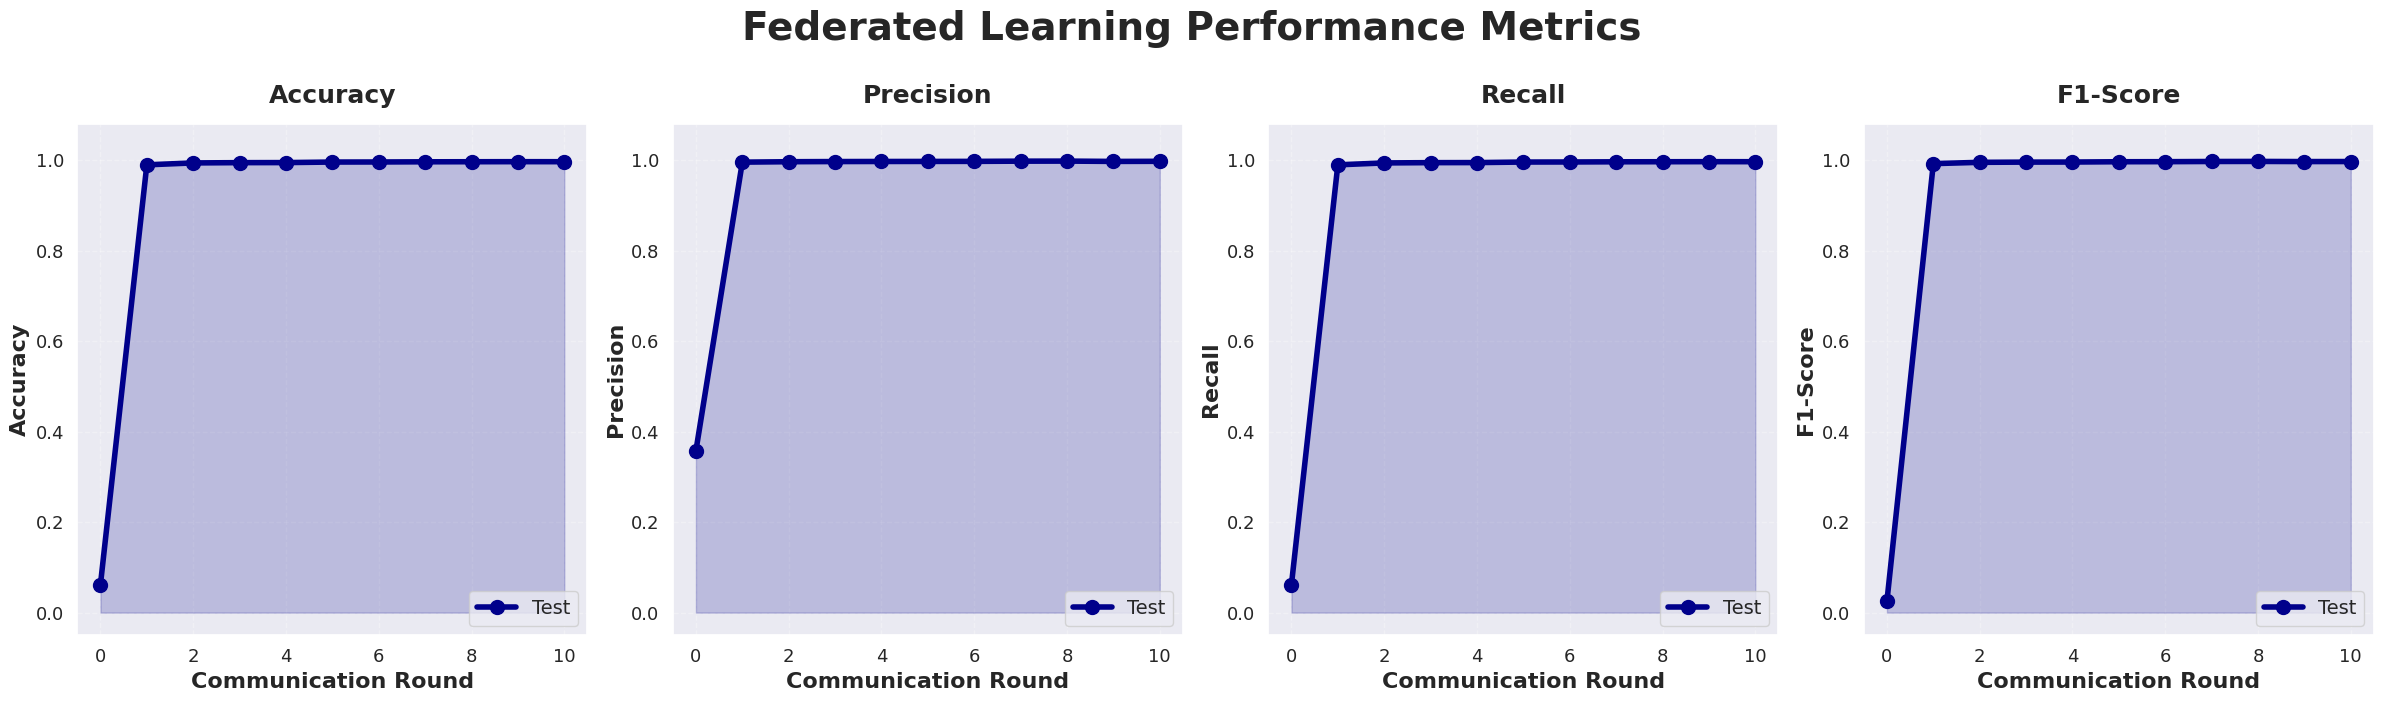

In [79]:
if not df.empty:
    # Define metrics to plot
    metrics_show = ["accuracy","precision","recall","f1score"]
    metric_labels = ["Accuracy", "Precision", "Recall", "F1-Score"]

    # Create a larger figure with better spacing
    fig = plt.figure(figsize=(24, 7))
    fig.suptitle('Federated Learning Performance Metrics', fontsize=28, fontweight='bold', y=1.00)

    # Loop over the communication round history and metrics
    for i in range(len(metrics_show)):
        ax = plt.subplot(1, len(metrics_show), i + 1)

        # Get metric data
        metric_dict = commun_metrics_history.metrics_centralized
        rounds, values = zip(*metric_dict[metrics_show[i]])

        # Plot with enhanced styling
        ax.plot(np.asarray(rounds), np.asarray(values), color=colors[5], linewidth=4, marker='o', markersize=10, label='Test')
        ax.fill_between(np.asarray(rounds), np.asarray(values), alpha=0.2, color=colors[5])

        # Styling
        ax.set_xlabel('Communication Round', fontsize=16, fontweight='bold')
        ax.set_ylabel(metric_labels[i], fontsize=16, fontweight='bold')
        ax.set_title(metric_labels[i], fontsize=18, fontweight='bold', pad=15)
        ax.set_ylim(-0.05, 1.08)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=14, loc='lower right')
        ax.tick_params(labelsize=13)
        ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()

In [ ]:
if not df.empty:
    # Define metrics in a dataframe
    metrics_DNN = {'metric_name':  ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
               'set_used': ['Test', 'Test', 'Test', 'Test'],
               'metric_value': [ global_acc_test , global_pre_test , global_rec_test , global_f1s_test]
            }

    metrics_DNN = pd.DataFrame(metrics_DNN, columns = ['metric_name', 'set_used','metric_value'])

    # Plot metrics with improved styling
    fig = go.Figure(data=[
        go.Bar(
            name='Test',
            x=metrics_DNN[metrics_DNN['set_used']=="Test"]['metric_name'],
            y=metrics_DNN[metrics_DNN['set_used']=="Test"]['metric_value'],
            marker_color='#0091ad',
            marker_line_color='#005f7a',
            marker_line_width=2,
            text=[f"{v:.4f}" for v in metrics_DNN[metrics_DNN['set_used']=="Test"]['metric_value']],
            textposition='outside',
            textfont=dict(size=14, color='#005f7a')
        )
    ])

    # Update layout for better appearance
    fig.update_layout(
        title=dict(
            text='<b>Final Federated Learning Model Performance</b>',
            font=dict(size=22, color='#005f7a'),
            x=0.5,
            xanchor='center'
        ),
        xaxis_title='<b>Metric</b>',
        yaxis_title='<b>Metric Value</b>',
        xaxis_title_font=dict(size=16),
        yaxis_title_font=dict(size=16),
        xaxis_tickfont=dict(size=14),
        yaxis_tickfont=dict(size=14),
        barmode='group',
        autosize=False,
        width=900,
        height=600,
        showlegend=False,
        plot_bgcolor='rgba(240,240,240,0.5)',
        margin=dict(l=100, r=100, t=100, b=100),
        yaxis=dict(range=[0, 1.1])
    )
    fig.show()